In [23]:
%pip install pyro-ppl

Note: you may need to restart the kernel to use updated packages.


In [46]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
from multiprocessing import get_context
import torch
import pyro
from pyro.infer import MCMC, NUTS
import pyro.distributions as dist
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from typing import Tuple
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, classification_report

In [25]:
# Step 1: Load the dataset
# Assuming the dataset is in CSV format and you have the path to it
data = pd.read_csv('data.csv')

In [26]:
# Step 2: Prepare features (X) and target (y)
X = data.drop(columns=['vital.status'])  # Drop the target column to get the features
y = data['vital.status']  # Target variable (0 = survived, 1 = died)

# Step 3: Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:

# Step 4: Initialize and train the Logistic Regression model
start_time = time.time()
asd = 1;
log_reg = LogisticRegression(max_iter=1000, solver='lbfgs')
log_reg.fit(X_train, y_train)
end_time = time.time()

print(f"Training time: {end_time - start_time} seconds")

Training time: 0.12465906143188477 seconds


In [28]:
# Step 5: Make predictions on the test set
y_pred = log_reg.predict(X_test)

# Step 6: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Output the results
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 82.98%
Confusion Matrix:
[[115  10]
 [ 14   2]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.91       125
           1       0.17      0.12      0.14        16

    accuracy                           0.83       141
   macro avg       0.53      0.52      0.52       141
weighted avg       0.81      0.83      0.82       141



MLP

MLP Training time: 1.3066012859344482 seconds
MLP Accuracy: 0.8652482269503546
              precision    recall  f1-score   support

           0       0.91      0.94      0.93       125
           1       0.36      0.25      0.30        16

    accuracy                           0.87       141
   macro avg       0.64      0.60      0.61       141
weighted avg       0.85      0.87      0.85       141



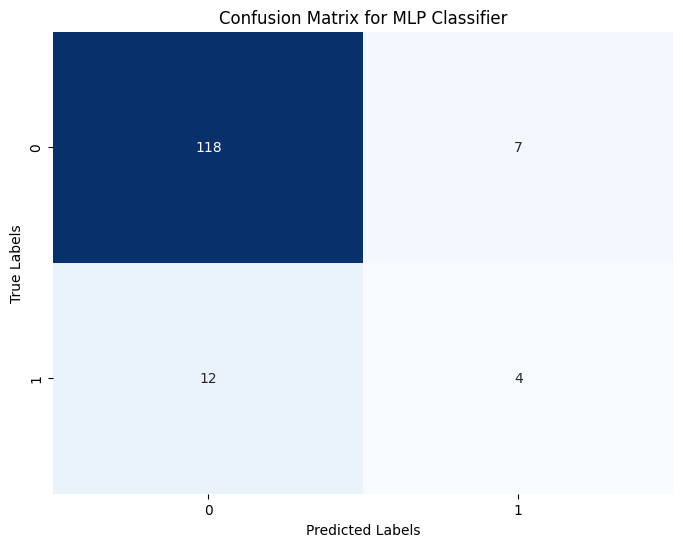

In [29]:
# MLP Classifier (Multi-Layer Perceptron)
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)  # You can adjust hidden_layer_sizes

# Timing the MLP training
start_time = time.time()
mlp_model.fit(X_train, y_train)
end_time = time.time()
mlp_train_time = end_time - start_time

# Predict and evaluate MLP model
mlp_preds = mlp_model.predict(X_test)
mlp_accuracy = accuracy_score(y_test, mlp_preds)

print(f"MLP Training time: {mlp_train_time} seconds")
print(f"MLP Accuracy: {mlp_accuracy}")

# Confusion Matrix for MLP Model
mlp_cm = confusion_matrix(y_test, mlp_preds)

mlp_class_report = classification_report(y_test, mlp_preds)

print(mlp_class_report)

# Plotting the confusion matrix using seaborn heatmap
plt.figure(figsize=(8,6))
sns.heatmap(mlp_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for MLP Classifier')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Bayesian Logical Regression

In [30]:
scaler=StandardScaler()

X = data.drop(columns=['vital.status'])
y = data['vital.status']
scaled_data=scaler.fit_transform(X)

# Step 2: Prepare features (X) and target (y)
  # Drop the target column to get the features
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.int32)
  # Target variable (0 = survived, 1 = died)

# Step 3: Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



MCMC

In [31]:
NUM_OF_SAMPLES = 1000
NUM_OF_CHAINS = 1



def logistic_regression_model(features: torch.Tensor, target: torch.Tensor):
    # sample from prior
    W = pyro.sample(
        "weight", dist.Normal(torch.zeros(1, features.shape[1]), torch.ones(1, features.shape[1])).independent(1)
    )
    b = pyro.sample(
        "bias", dist.Normal(torch.zeros(1), torch.ones(1)).independent(1)
    )
    with pyro.plate("data", features.size(0)):
        # Generate raw model logits
        model_logits = (torch.matmul(features, W.permute(1, 0)) + b).squeeze()
        # Apply sigmoid function
        probs = torch.sigmoid(model_logits)
        pyro.sample(
            "obs",
            dist.Bernoulli(probs=probs),
            obs=target.squeeze())

def run_inference(features: torch.Tensor, target: torch.Tensor, number_of_samples: int, number_of_chains:int) -> MCMC:
    # Initialise NUTS sampler
    kernel = NUTS(logistic_regression_model)
    # Initialise MCMC class
    mcmc = MCMC(kernel, num_samples = number_of_samples, warmup_steps = 200, num_chains=number_of_chains)
    # Run sampling
    mcmc.run(features.float(), target.float())
    return mcmc


In [32]:
mcmc = run_inference(X_train, y_train, number_of_samples=NUM_OF_SAMPLES, number_of_chains=NUM_OF_CHAINS)

Sample: 100%|██████████| 1200/1200 [3:17:39,  9.88s/it, step size=3.88e-03, acc. prob=0.956]


In [33]:
mcmc.summary()


                    mean       std    median      5.0%     95.0%     n_eff     r_hat
       bias[0]     -0.04      1.00     -0.05     -1.74      1.53   2710.31      1.00
   weight[0,0]      0.57      0.58      0.58     -0.45      1.44    606.72      1.00
   weight[0,1]     -0.59      0.69     -0.57     -1.62      0.61    694.55      1.00
   weight[0,2]      0.19      0.80      0.19     -1.14      1.45    880.13      1.00
   weight[0,3]      0.26      0.81      0.22     -1.02      1.57    648.17      1.00
   weight[0,4]     -0.89      0.83     -0.88     -2.16      0.56    920.03      1.00
   weight[0,5]      0.46      0.77      0.44     -0.85      1.64   1060.07      1.00
   weight[0,6]     -0.68      0.55     -0.68     -1.63      0.14    463.47      1.00
   weight[0,7]      0.25      0.80      0.24     -1.00      1.60    747.44      1.00
   weight[0,8]     -0.10      0.92     -0.10     -1.51      1.49   1422.60      1.00
   weight[0,9]      0.66      0.88      0.67     -0.79      2.03

In [35]:
def create_predictions(samples: dict, dataset: torch.tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    # Create tensor of zeros with shape (number of samples x number of examples)
    obs_samples = torch.zeros(samples["weight"].shape[0], dataset.shape[0])
    # Iterate through every set of samples
    for i in range(samples["weight"].shape[0]):
        W_sample = samples["weight"][i]
        b_sample = samples["bias"][i]

        model_logits = (torch.matmul(dataset, W_sample.permute(1, 0)) + b_sample).squeeze()
        probs = torch.sigmoid(model_logits)

        obs_samples[i] = probs
    # Calculate the mean prediction per example
    mean_predictions = obs_samples.mean(dim=0)
    # Classify the prediction 
    class_predictions = (obs_samples.mean(dim=0)>0.5).int()

    return class_predictions, obs_samples, mean_predictions


# Draw ungrouped samples
samples_ungrouped = mcmc.get_samples()

# Training predictions
train_class_predictions, train_prediction_samples, train_mean_predictions = create_predictions(samples_ungrouped, X_train)
# Test predictions
test_class_predictions, test_prediction_samples,test_mean_predictions = create_predictions(samples_ungrouped, X_test)

In [36]:
def calculate_classification_metrics(true_labels:torch.Tensor, predicted_labels:torch.Tensor, prob_scores:torch.Tensor) -> dict:
    metrics = {}
    
    # Accuracy
    metrics['Accuracy'] = accuracy_score(true_labels, predicted_labels)

    # Precision
    metrics['Precision'] = precision_score(true_labels, predicted_labels)

    # Recall
    metrics['Recall'] = recall_score(true_labels, predicted_labels)

    # F1 Score
    metrics['F1 Score'] = f1_score(true_labels, predicted_labels)

    # ROC Curve
    metrics['ROC Score']  = roc_curve(true_labels, prob_scores)

    # AUC-ROC
    metrics['AUC-ROC'] = roc_auc_score(true_labels, prob_scores)

    return metrics

In [37]:
metrics_test = calculate_classification_metrics(y_test, test_class_predictions, test_mean_predictions)
df_test = pd.DataFrame(metrics_test).drop(columns = ['ROC Score'], axis =1).drop_duplicates()
df_test.index = ['Test']
for metric, value in metrics_test.items():
    if metric != 'ROC Score':
        print(f"{metric}: {value}")

Accuracy: 0.8581560283687943
Precision: 0.25
Recall: 0.125
F1 Score: 0.16666666666666666
AUC-ROC: 0.5890000000000001


Bayesian MLP

In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the fully connected neural network
# Fully Connected Neural Network (MLP) with conditional dropout during inference
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        # Define layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, num_classes)
        
        # Define dropout layers with fixed probabilities
        self.dropout1 = nn.Dropout(p=0.25)
        self.dropout2 = nn.Dropout(p=0.5)

    def forward(self, x, training=True):
        # First fully connected layer
        x = F.relu(self.fc1(x))
        x = self.dropout1(x) if training else x  # Apply dropout1 only if training=True
        
        # Second fully connected layer
        x = F.relu(self.fc2(x))
        x = self.dropout2(x) if training else x  # Apply dropout2 only if training=True
        
        # Output layer
        x = self.out(x)
        return F.log_softmax(x, dim=1)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam

# Function to train the model
def train_model(model, train_loader, criterion, optimizer, epochs=20):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}')

# Function to evaluate the model and return accuracy
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    true_labels = []
    with torch.no_grad():
        for batch in test_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.append(predicted.cpu())
            true_labels.append(labels.cpu())
    
    all_preds = torch.cat(all_preds)
    true_labels = torch.cat(true_labels)
    
    accuracy = accuracy_score(true_labels, all_preds)
    print(f'Accuracy: {accuracy:.4f}')
    return accuracy

Using device: cpu


Acquisition functions

Uniform acquisition

In [43]:
def uniform(model, dataset, pool_indices, n_query, T=100, training=True):
    """
    Uniformly random selection of data points from the unlabeled pool.
    
    Args:
    pool_indices (list): List of indices available in the pool.
    n_query (int): Number of queries to make.
    
    Returns:
    list: Indices of the selected data points.
    """
    # Directly use the pool_indices to select data points
    selected_indices = np.random.choice(pool_indices, size=n_query, replace=False)
    
    return selected_indices.tolist()

Max Entropy acquisition

In [48]:
def predictions_from_pool(model, dataset, pool_indices, T=100, training=True):
    """
    Run MC dropout prediction on model using graphs from the pool and return the output.
    """
    # Randomly select indices from the pool
    random_subset = np.random.choice(pool_indices, size=min(2000, len(pool_indices)), replace=False)
    
    # Fetch the actual data from the dataset
    inputs = torch.stack([dataset[i][0] for i in random_subset]).to(device)  # Extract input features
    
    # Perform prediction
    outputs = []
    with torch.no_grad():
        for _ in range(T):
            model.train(training)  # Enable/disable dropout
            output = torch.softmax(model(inputs, training=training), dim=-1)  # Forward pass with MC Dropout
            outputs.append(output.cpu().numpy())
    
    outputs = np.stack(outputs)
    print("outputs shape: ",outputs.shape)
    
    return outputs, random_subset

def shannon_entropy_function(model, dataset, pool_indices, T=100, E_H=False, training=True):
    """
    Compute the Shannon entropy and optionally E_H if needed for BALD.
    """
    outputs, random_subset = predictions_from_pool(model, dataset, pool_indices, T, training)
    pc = outputs.mean(axis=0)
    H = (-pc * np.log(pc + 1e-10)).sum(axis=-1)  # Prevent log(0)

    if E_H:
        E = -np.mean(np.sum(outputs * np.log(outputs + 1e-10), axis=-1), axis=0)
        return H, E, random_subset
    return H, random_subset

def max_entropy(model, dataset, pool_indices, n_query=10, T=100, training=True):
    """
    Choose pool points that maximize the predictive entropy.
    """
    acquisition, random_subset = shannon_entropy_function(model, dataset, pool_indices, T, training=training)
    idx = (-acquisition).argsort()[:n_query]
    query_idx = random_subset[idx]
    return query_idx

In [61]:
def active_learning_loop(model, dataset, initial_indices, pool_indices, val_indices, test_indices, strategy, n_query=10, epochs=100):
    accuracies = []

    # Extract the features (X) and labels (y) from the dataset
    X_all, y_all = dataset.tensors
    
    # Create data loaders with selected indices
    train_loader = DataLoader(TensorDataset(X_all[initial_indices], y_all[initial_indices]), batch_size=32, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_all[val_indices], y_all[val_indices]), batch_size=32, shuffle=False)
    test_loader = DataLoader(TensorDataset(X_all[test_indices], y_all[test_indices]), batch_size=32, shuffle=False)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Initial training
    print("Initial Training Phase")
    train_model(model, train_loader, criterion, optimizer, epochs=20)
    val_acc = evaluate_model(model, val_loader)
    accuracies.append(val_acc)
    
    for epoch in range(epochs):
        print(f"Active Learning Epoch {epoch + 1}")
        train_model(model, train_loader, criterion, optimizer, epochs=10)
        val_acc = evaluate_model(model, val_loader)
        accuracies.append(val_acc)

        # Acquire new samples based on the selected strategy (e.g., max_entropy, uniform)
        new_indices = strategy(model, dataset, pool_indices, n_query)
        initial_indices = np.concatenate([initial_indices, new_indices])
        pool_indices = np.setdiff1d(pool_indices, new_indices)

        # Recreate train_loader with updated indices
        train_loader = DataLoader(TensorDataset(X_all[initial_indices], y_all[initial_indices]), batch_size=32, shuffle=True)
        print(f"New training data size: {len(initial_indices)}, Remaining pool size: {len(pool_indices)}")

    # Final evaluation on test set
    test_acc = evaluate_model(model, test_loader)
    print(f"Final Test Accuracy: {test_acc:.4f}")

    return accuracies



    
    


In [62]:
X = data.drop(columns=['vital.status'])  # Drop the target column to get the features
y = data['vital.status']  # Target variable (0 = survived, 1 = died)

# Standardize the feature values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert to torch tensors
X = torch.tensor(X_scaled, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.long)  # Ensure target is of type long for classification

# Step 2: Split the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Combine all data for the active learning dataset
X_all = torch.cat([X_train, X_test])
y_all = torch.cat([y_train, y_test])
dataset = TensorDataset(X_all, y_all)

# Initial labeled indices, pool, validation, and test indices
initial_indices = np.random.choice(len(X_train), size=100, replace=False)  # Start with 100 random samples
pool_indices = np.setdiff1d(np.arange(len(X_train)), initial_indices)  # Remaining unlabeled pool
val_indices = np.random.choice(pool_indices, size=100, replace=False)  # Validation set from the pool
pool_indices = np.setdiff1d(pool_indices, val_indices)
test_indices = np.arange(len(X_train), len(X_all))  # Test set is the entire X_test


dataset = TensorDataset(X_all, y_all)

# Initial labeled indices, pool, validation, and test indices
initial_indices = np.random.choice(len(X_train), size=100, replace=False)  # Start with 100 random samples
pool_indices = np.setdiff1d(np.arange(len(X_train)), initial_indices)  # Remaining unlabeled pool
val_indices = np.random.choice(pool_indices, size=100, replace=False)  # Validation set from the pool
pool_indices = np.setdiff1d(pool_indices, val_indices)
test_indices = np.arange(len(X_train), len(X_all))  # Test set is the entire X_test

# Model and active learning setup
input_size = X_train.shape[1]  # Number of features
hidden_size = 128
num_classes = len(torch.unique(y_train)) 

model=MLP(input_size, hidden_size, num_classes).to(device)
# Example usage of BALD with the updated MLP and dropout during inference
strategy = max_entropy  # You can switch this to max_entropy or uniform as needed

# Run the active learning loop
accuracies = active_learning_loop(model, dataset, initial_indices, pool_indices, val_indices, test_indices, strategy, n_query=10, epochs=20)

Initial Training Phase
Epoch [1/20], Loss: 0.5545
Epoch [2/20], Loss: 0.2821
Epoch [3/20], Loss: 0.2293
Epoch [4/20], Loss: 0.1463
Epoch [5/20], Loss: 0.1048
Epoch [6/20], Loss: 0.0772
Epoch [7/20], Loss: 0.0584
Epoch [8/20], Loss: 0.0489
Epoch [9/20], Loss: 0.0378
Epoch [10/20], Loss: 0.0166
Epoch [11/20], Loss: 0.0148
Epoch [12/20], Loss: 0.0095
Epoch [13/20], Loss: 0.0076
Epoch [14/20], Loss: 0.0037
Epoch [15/20], Loss: 0.0047
Epoch [16/20], Loss: 0.0026
Epoch [17/20], Loss: 0.0047
Epoch [18/20], Loss: 0.0021
Epoch [19/20], Loss: 0.0029
Epoch [20/20], Loss: 0.0022
Accuracy: 0.8200
Active Learning Epoch 1
Epoch [1/10], Loss: 0.0027
Epoch [2/10], Loss: 0.0014
Epoch [3/10], Loss: 0.0012
Epoch [4/10], Loss: 0.0008
Epoch [5/10], Loss: 0.0005
Epoch [6/10], Loss: 0.0005
Epoch [7/10], Loss: 0.0003
Epoch [8/10], Loss: 0.0017
Epoch [9/10], Loss: 0.0005
Epoch [10/10], Loss: 0.0007
Accuracy: 0.8200
outputs shape:  (100, 364, 2)
New training data size: 110, Remaining pool size: 354
Active Learni